In [28]:
from typing import Annotated
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict
from langchain_core.tools import Tool 
from loguru import logger

In [29]:
load_dotenv(override=True)

True

In [30]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... The capital of France has been Paris since its liberation in 1944. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... PARIS it is the capital and largest city of France. Located on the Seine in the country\'s north, it is a major cultural and political centre o

## langchain wrapper classs convert funcations to tool

In [31]:
tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search")

In [32]:
tool_search

Tool(name='search', description='Useful for when you need more information from an online search', func=<bound method GoogleSerperAPIWrapper.run of GoogleSerperAPIWrapper(k=10, gl='us', hl='en', type='search', result_key_for_type={'news': 'news', 'places': 'places', 'images': 'images', 'search': 'organic'}, tbs=None, serper_api_key='245a4482074325ef751a303882b0c461a3495ef6', aiosession=None)>)

In [33]:
tool_search.invoke("What is the captial of france")

'Paris is the capital and largest city of France, with an estimated city population of 2,048,472 in an area of 105.4 km2 (40.7 sq mi), and a metropolitan ... Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... The capital of France has been Paris since its liberation in 1944. Paris, the capital and largest city of France, is located in the northern part of the country on the banks of the Seine River. Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capit

## And now lets write own a tool resources 

In [34]:
PUSHOVER_USER=os.getenv("PUSHOVER_USER")
PUSHOVER_TOKEN=os.getenv("PUSHOVER_TOKEN")
PUSHOVER_URL=os.getenv("PUSHOVER_URL")

In [35]:
PUSHOVER_TOKEN

'umnmtj7piacqgcvawarue673dzan74'

In [36]:
def push(txt:str):
    """ Send a push notification to the user """
    logger.info(txt)
    requests.post(PUSHOVER_URL, data={"token":PUSHOVER_USER, "user":PUSHOVER_TOKEN, "message": txt})

In [37]:
tool_push=Tool(
    name="send_push_notification",
    description="Useful when you want to send push notification.",
    func=push
)

In [38]:
tool_push

Tool(name='send_push_notification', description='Useful when you want to send push notification.', func=<function push at 0x0000017701AED850>)

In [39]:
tool_push.invoke("Hello, me dfs")

2025-10-26 09:45:10.351 | INFO     | __main__:push:3 - Hello, me dfs


In [40]:
tools=[tool_search,tool_push]

## Back to LangGraph 

### One small change - using TypedDict instead of BaseModel for the state objec
### When we make tools, we always need to make 2 changes to the code.

    1- Changes to provide the tools to OpenAI in JSON when we make the call. 
    2- change to handle the results back. Look for the model staying that the finish_reason "tool_calls" and then retrieve the call, run the function, and provide the results. 

In [61]:
# Step1- Define the state object 
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [62]:
# step2: the graph builder with state class
graph_builder=StateGraph(State)

In [63]:
# Step3: 

In [64]:
llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

In [65]:
## Step3: create nodes

In [66]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [67]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

In [68]:
## setp 4: create graph edge
graph_builder.add_conditional_edges("chatbot", tools_condition,"tools")
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START,"chatbot")
# graph_builder.add_edge("chatbot",END)

In [69]:
graph=graph_builder.compile()

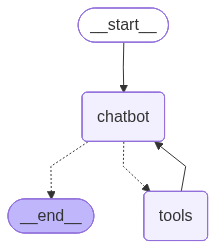

In [70]:
graph

In [71]:
def chat(user_input,history):
    result=graph.invoke({"messages":[{"role":"user","content":user_input}]})
    return result["messages"][-1].content

In [72]:
gr.ChatInterface(chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


## Memory

In [41]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [42]:
#Step1: Create State
class State(TypedDict):
    messages: Annotated[list,add_messages]

#Step2: Build Graph
llm=ChatOpenAI(model="gpt-4o-mini")
llm_with_tools=llm.bind_tools(tools)

graph_builder=StateGraph(State)

#step3 Create node 
def chatbot(state:State):
    logger.info(state)
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools=tools))

#Step4: 
graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot",END)

#STEP 5: Graph compile

graph=graph_builder.compile(checkpointer=memory)


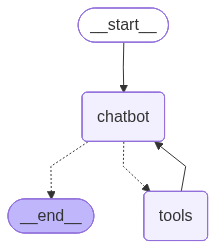

In [43]:
graph

In [44]:
config={"configurable":{"thread_id":"1"}}

In [45]:
def chat(user_input:str,history):
    result=graph.invoke({"messages":[{"role":"user","content":user_input}]}, config=config)
    return result["messages"][-1].content

In [46]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [47]:
graph.get_state(config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

2025-10-26 09:45:36.953 | INFO     | __main__:chatbot:13 - {'messages': [HumanMessage(content='hi there\n', additional_kwargs={}, response_metadata={}, id='caa3c4b7-9482-48ba-8ef5-f79665da2fa5')]}


In [27]:
graph.get_state_history(config=config)

<generator object Pregel.get_state_history at 0x0000017701955FE0>

2025-10-26 09:44:45.087 | INFO     | __main__:chatbot:13 - {'messages': [HumanMessage(content='Hi My name is bharat', additional_kwargs={}, response_metadata={}, id='f622d5ff-385f-459d-b0d8-a9e5cbc5d878'), AIMessage(content='Hello Bharat! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 92, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUmPbCHflzjzn0OuMYhk9daX8UEMP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--68f55a9a-fbd4-488b-b89d-6a7bdc65db80-0', usage_metadata={'input_tokens': 92, 'output_tokens': 11, 'total_tokens': 103, 'input_token_details': {'audi